# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [33]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [34]:
def read_data(path="/data/notebook_files/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(37)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [35]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [36]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.sum((y_true - y_predicted) ** 2) / y_true.shape[0]

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    return 1 - np.sum((y_true - y_predicted) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [37]:
class NormalLR:
    def __init__(self):
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        A = np.column_stack((np.ones_like(X[:, 0]), X))
        self.w = np.linalg.inv(A.T @ A) @ A.T @ y

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.column_stack((np.ones_like(X[:, 0]), X)) @ self.w.T

In [38]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [39]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009242925253569286, R2: 0.9986778252870173


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [40]:
class GradientLR:
    def __init__(self, alpha: float, iterations=10000, l=0.):
        self.w = None
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        A = np.column_stack((np.ones_like(X[:, 0]), X))
        self.w = np.random.uniform(-1, 1, size=A.shape[1])
        for _ in range(self.iterations):
            self.w -= self.alpha * (A.T @ (A @ self.w - y) / len(A) + self.l * np.sign(self.w))
        

    def predict(self, X: np.ndarray):
        return np.column_stack((np.ones_like(X[:, 0]), X)) @ self.w 

In [41]:
def build_plot(X_train, y_train, X_test, y_test):
    ls = np.arange(-0.5, 1, 0.001)
    errors = []
    for l in ls:
        regr = GradientLR(0.1, 100, l)
        regr.fit(X_train, y_train)
        error = mse(y_test, regr.predict(X_test))
        errors.append(error)
    errors = np.array(errors)
    plt.figure(figsize=(25, 20))
    plt.xlabel('regularization coef')
    plt.ylabel('MSE')
    plt.plot(ls, errors)
    print(f'min at l = {ls[np.argmin(errors)]}, min error = {np.min(errors)}')

In [42]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

min at l = -0.0029999999999995586, min error = 0.01091806321514021


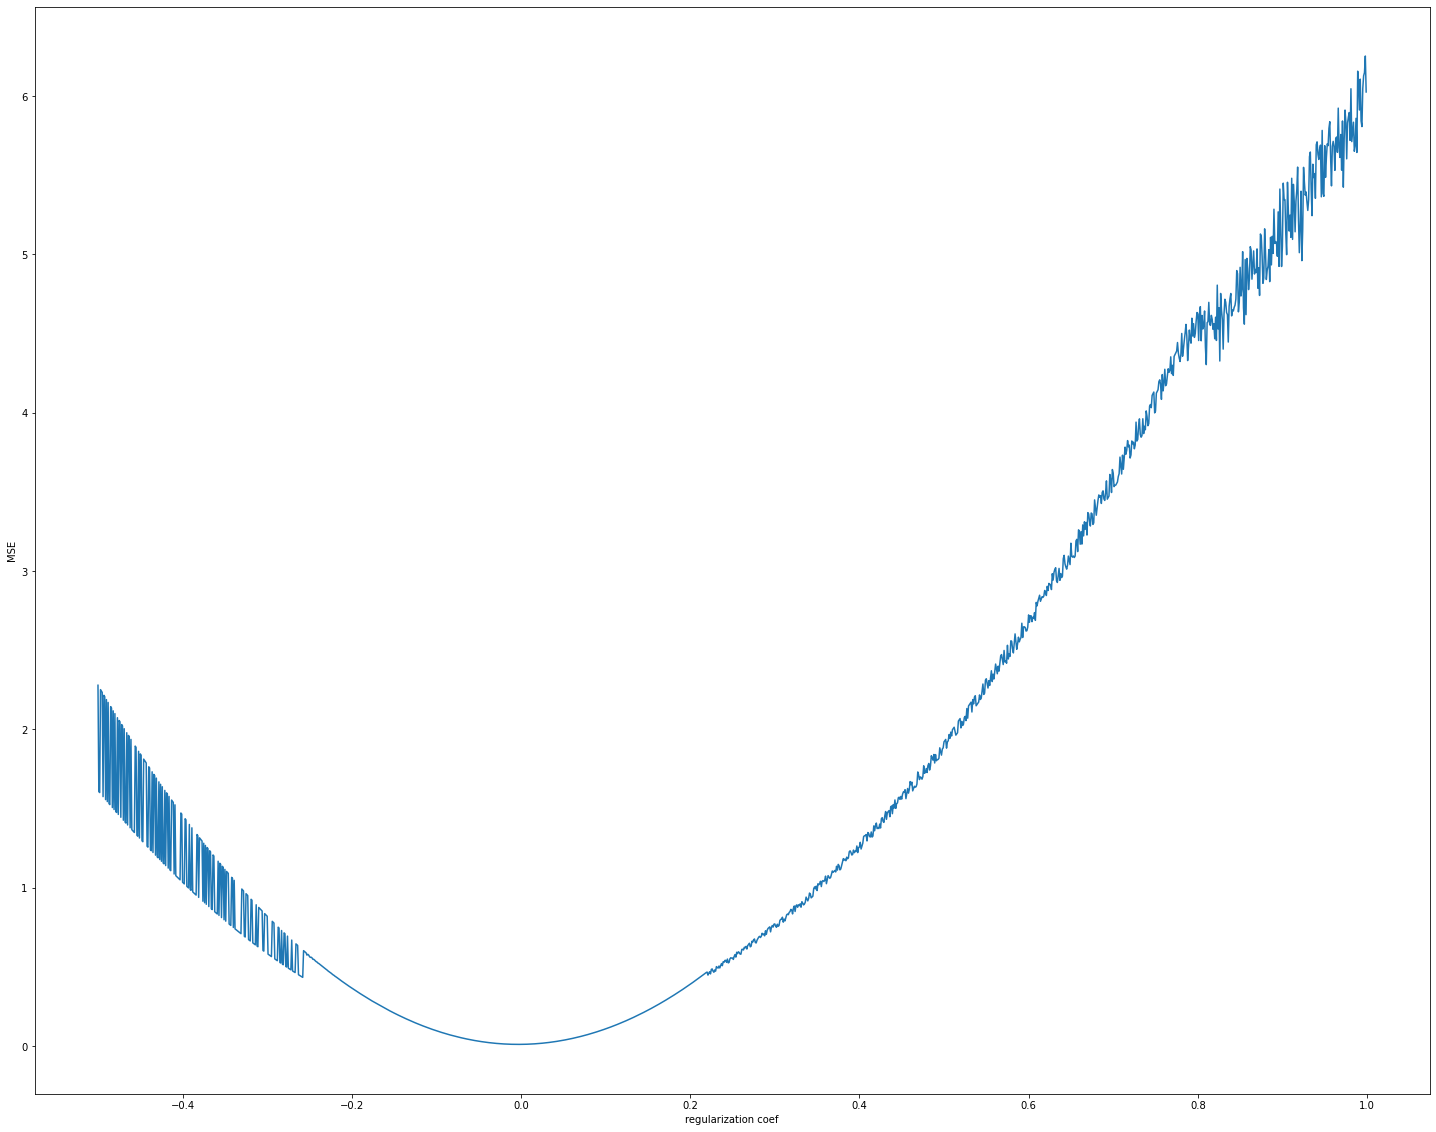

In [43]:
build_plot(X_train, y_train, X_val, y_val)

In [44]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.008541745894292086, R2: 0.9982659588436439


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [45]:
X, y = read_data()
X = scale(X)
y = scale(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [46]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.22796702864434643, R2: 0.7565292381871431


In [47]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.22796702864434684, R2: 0.7565292381871427
